<img src="https://www.arm.gov/uploads/ECOR_new_SGP1.jpg" width=800 alt="ARM ECOR Banner"></img>

# Surface Flux Analysis

---

## Overview
The Atmospheric Radiation Measurement (ARM) user facility has a significant data record of surface flux (momentum, sensible and latent heat, and CO2) data available at multiple locations around the Southern Great Plains (SGP) observatory.  This project will explore long-term data analysis of the fluxes and break down the flux statistics by vegetation type.  Students will gain experience with Python, surface flux data, ARM, and open-source software. Topics included in this notebook are:

1. What is the ARM Eddy Correlation Measurement System (ECOR)?
1. Downloading and Reading in ECOR data
1. Quality controlling ECOR data at SGP
1. Crop Type Information
1. Putting it all together!

## Prerequisites
This notebook will rely heavily on Python and the [Atmospheric data Community Toolkit (ACT)](https://github.com/ARM-DOE/ACT).  Don't worry if you don't have experience with either, this notebook will walk you though what you need to know.

You will also need an account and token to download data using the ARM Live webservice.  Navigate to the [webserive information page](https://adc.arm.gov/armlive/) and log in to get your token.  Your account username will be your ARM username.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [ACT](https://github.com/ARM-DOE/ACT) | Helpful | |

- **Time to learn**: 60 Minutes
- **System requirements**:
    - Python 3.11 or latest
    - ACT v1.4.5 or latest
    - numpy
    - xarray
    - matplotlib

---

## Imports

In [1]:
import act
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import urllib3
import warnings
import os
from datetime import datetime, timedelta
from distributed import Client 
warnings.simplefilter('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 7.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54855,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 7.37 GiB
Comm: tcp://127.0.0.1:54876,Total threads: 2
Dashboard: http://127.0.0.1:54877/status,Memory: 2.46 GiB
Nanny: tcp://127.0.0.1:54858,


## What is the ARM Eddy Correlation Measurement System (ECOR)?

The eddy correlation (ECOR) flux measurement system provides half-hour measurements of the surface turbulent fluxes of momentum, sensible heat, latent heat, and carbon dioxide. The ECOR uses the eddy covariance technique, which involves correlation of the vertical wind component with the horizontal wind component, air temperature, water vapor density, and CO2 density.

More information on the system can be found on [ARM's ECOR instrument page](https://arm.gov/capabilities/instruments/ecor).  Please note that the [Instrument Handbook](https://www.arm.gov/publications/tech_reports/handbooks/ecor_handbook.pdf) has a lot of useful information in it as well, including some good quality control information that will come in handy later.

### Why are fluxes important?

Land-atmosphere interactions (LAI) are the main drivers of earth's surface water and energy budgets.  Understanding how energy, heat, and greenhouse gases flow from the surface is important for verifying and improving global climate models.  Understanding the impact crop type has on these fluxes can have wide impacts as 52% of the U.S. land base is used for agriculture ([USDA](https://www.ers.usda.gov/topics/farm-economy/land-use-land-value-tenure/#:~:text=Agricultural%20production%20is%20a%20major,of%20the%20U.S.%20land%20base.)) with the Food and Agriculture Organization of the United Nations indicating that roughly 38% of the entire world is dedicated to agriculture.

## Choosing a Start and End Date
Run the cell and input your start and end year, month and day.  Dates in the datasets range from 10/19/2010 to 10/22/2019.  WARNING!!!  Choosing more than around 4 years worth of data at a time is NOT currently recommended.  Doing so will result in very long run times for downloading, processing, and plotting the data.  Choose dates at your own risk.

In [4]:
#Choose dates
startdate = datetime(int(input(f'Input Start Year:')), int(input(f'Input Start Month:')), int(input(f'Input Start Day:')))
enddate = datetime(int(input(f'Input End Year:')), int(input(f'Input End Month:')), int(input(f'Input End Day:')))
#Convert them to numbers only
date1 = startdate.strftime('%Y%m%d')
date2 = enddate.strftime('%Y%m%d')

Input Start Year:2018
Input Start Month:4
Input Start Day:1
Input End Year:2018
Input End Month:9
Input End Day:30


## Downloading and Reading in ARM Data
In this section, you will download data from ARM's Live Data Web Service and read it in to an xarray dataset using ACT.  __Warning!  Do not commit your username and token to the Github repo!  You do not want to make these public__

If you read the instrument webpage, it noted that the 30ecor datastream has the uncorrected fluxes and it's recommended that routine ECOR corrections are applied.  The corrected data are available in the 30qcecor Value-Added Product (VAP) so that is what we are going to be working with.  Note that this dataset is only available from 2010 onward and the SGP ECOR systems were upgraded in October 2019 and are producing corrected fluxes in the ECORSF datastream.  While the QCECOR product has corrected fluxes it doees not include wind direction and speed that we will need later on so we will need to download both the QCECOR and base ECOR data products.

These definitions subset the data to only include certain variables necessary for plotting. This helps to reduce the time it takes to read everything in.  For more information about all the variables included in both datasets, check out https://doi.org/10.5439/1097546 for the QC ECOR dataset and https://doi.org/10.5439/1025039 for the standard ECOR dataset.

In [5]:
#Subset for ECOR data
def subset_variables(ds_ecor):
    return ds_ecor[["h","lv","fc","wind_dir","wind_spd","lat","lon","base_time","time_offset"]]
#Subset for QC data
def subset_variables2(ds):
    return ds[["sensible_heat_flux","latent_heat_flux","lat","lon","base_time","time_offset"]]

# Downloading and Reading Everything in
Input the facility number of your choice (just the number) and the data will start downloading.

In [6]:
# Set your ARM Live data username and password.
username = 'nmarkus'
token = '643b246242abf8c3'
# If you don't know the datastream you can always download through data discovery as well
# https://adc.arm.gov/discovery/#/
# You can also easily change the facility (E14) to other ones as well
n = input(f'Facility Number:')
datastream = f'sgp30qcecorE{int(n)}.s1'
#Focus on 10/22/2010-10/19/2019
# Download data using the webservice
qcecor_files = act.discovery.download_data(username, token, datastream, date1, date2)
# Download ECOR data using the webservice
datastream = f'sgp30ecorE{int(n)}.b1'
ecor_files = act.discovery.download_data(username, token, datastream, date1, date2)
#Read in the data       
ds_ecor = xr.open_mfdataset(ecor_files,
                        preprocess=subset_variables)
ds = xr.open_mfdataset(qcecor_files,
                        preprocess=subset_variables2)

Facility Number:14
[DOWNLOADING] sgp30qcecorE14.s1.20180401.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180402.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180403.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180404.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180405.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180406.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180407.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180408.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180409.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180410.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180411.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180412.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180413.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180414.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180415.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180416.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180417.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180418.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180419.000000.nc
[DOWNLOADING

[DOWNLOADING] sgp30qcecorE14.s1.20180910.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180911.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180912.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180913.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180914.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180915.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180916.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180917.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180918.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180919.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180920.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180921.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180922.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180923.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180924.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180925.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180926.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180927.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180928.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1

[DOWNLOADING] sgp30ecorE14.b1.20180430.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180712.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180512.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180511.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180510.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180513.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180521.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180522.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180524.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180523.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180525.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180527.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180605.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180526.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180604.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180606.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180608.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180607.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180609.000000.cdf
[DOWNLOADING] sgp30ecorE14.b1.20180515.000000.cdf


In [7]:
ds_ecor

<xarray.Dataset>
Dimensions:      (time: 8780)
Coordinates:
  * time         (time) datetime64[ns] 2018-04-01 ... 2018-09-30T23:30:00
Data variables:
    h            (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    lv           (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    fc           (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    wind_dir     (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    wind_spd     (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    lat          (time) float32 36.61 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon          (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49 -97.49
    base_time    (time) datetime64[ns] 2018-04-01 2018-04-01 ... 2018-09-30
    time_offset  (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/40)
    command_line:              ecor_ingest -s sgp -f E14
    process_version:           ingest-ecor-13.4-0.el6
    dod_version:               30ecor-b1-2.2
    input_source:              /data/collection/sgp/sgpecorE14.00/2018_0401_0...
    site_id:                   sgp
    platform_id:               30ecor
    ...                        ...
    qc_bit_3_description:      Value is greater than the valid_max.
    qc_bit_3_assessment:       Bad
    qc_bit_4_description:      Difference between current and previous values...
    qc_bit_4_assessment:       Indeterminate
    ingest_software:           ingest-ecor-13.4-0.el6
    history:                   created by user dsmgr on machine ruby at 2018-...

In [8]:
ds

<xarray.Dataset>
Dimensions:             (time: 8780)
Coordinates:
  * time                (time) datetime64[ns] 2018-04-01 ... 2018-09-30T23:30:00
Data variables:
    sensible_heat_flux  (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    latent_heat_flux    (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    lat                 (time) float32 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon                 (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    base_time           (time) datetime64[ns] 2018-04-01 ... 2018-09-30
    time_offset         (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/21)
    Conventions:           CF-1.6
    title:                 Quality Controlled Eddy Correlation Flux Measureme...
    description1:          This VAP of surface latent and sensible heat flux\...
    description2:          Eddy correlation corrections applied: \nWebb-Pearm...
    description3:          LLNL added QC includes: \ndata range check, outlie...
    description4:          Additional QC is added on latent heat flux based o...
    ...                    ...
    authors:               Yunyan Zhang (zhang25@llnl.gov)
    qc_date:               Thu Jan 28 21:54:10 UTC 2016
    command_line:          idl -R -n qcecor -s sgp -f E14 -D -b 20030912 -e 2...
    input_datastreams:     sgp30ecorE14.b1 : 13.4 : 20180401.000000\nsgpsebsE...
    doi:                   10.5439/1097546
    history:               created by user dsmgr on machine ruby at 2019-10-0...

In [9]:
#Get variables in the proper format
ds['wind_dir'] = ds_ecor['wind_dir']
ds['wind_spd'] = ds_ecor['wind_spd']
ds['co2_flux'] = ds_ecor['fc']
wdir = ds['wind_dir'].values

# Group the Data and Quick Plots
With the ECOR measurements being taken every 30 minutes, having large time ranges will make the plots hard to read.  Fortunately, we can use the "groupby" function to group the data into different time intervals and average the values before plotting everything.  This will make the plots easier to read.  For smaller datasets (as in around a week or less), however, you may still want to plot the ungrouped data.  

NOTE: The "hour" grouby will take the data from each hour of a given day and group it with its corresponding hour of all the other days and take the overall average (for example, the data from hour 1 of a given day will be grouped with the data with all other hour 1s in the dataset, and then the overall average is taken).  This will result in a plot of up to 24 hours where each hour represents the average of all the data for that hour for each day, rather than each individual hourly average being plotted.  The "dayofyear" and "week" groupbys work similarly except they result in a plot of up to 365 days or up to 52 weeks, respectively, rather than a 24-hour plot.  The "dayofweek" groupby will result in a plot of up to 7 days.

In [10]:
#Determine whether or not you want to group the data
answer = input(f'Would you like to group the data by a time\n'
               'interval (Recommended for datasets > 7 days)? (y/n): ')
#If yes, determine what time interval you would like
if answer == 'y':    
    interval = input(f'For plots of hourly averages, enter "hour"\n'
                    'For plots of daily averages, enter "dayofyear" or "dayofweek"\n'
                    'For weekly averages, enter "week"\n'
                    'Enter your time interval here: ')
    ds_ecor_gb = ds_ecor.groupby(f'time.{interval}').mean('time')
    ds_gb = ds.groupby(f'time.{interval}').mean('time')
    h = ds_gb.sensible_heat_flux
    lv = ds_gb.latent_heat_flux
    fc = ds_ecor_gb.fc
    wspd = ds_gb.wind_spd
#If no, the data will be left as is
elif answer == 'n':
    h = ds.sensible_heat_flux
    lv = ds.latent_heat_flux
    fc = ds_ecor.fc
    wspd = ds.wind_spd

Would you like to group the data by a time
interval (Recommended for datasets > 7 days)? (y/n): y
For plots of hourly averages, enter "hour"
For plots of daily averages, enter "dayofyear" or "dayofweek"
For weekly averages, enter "week"
Enter your time interval here: dayofyear


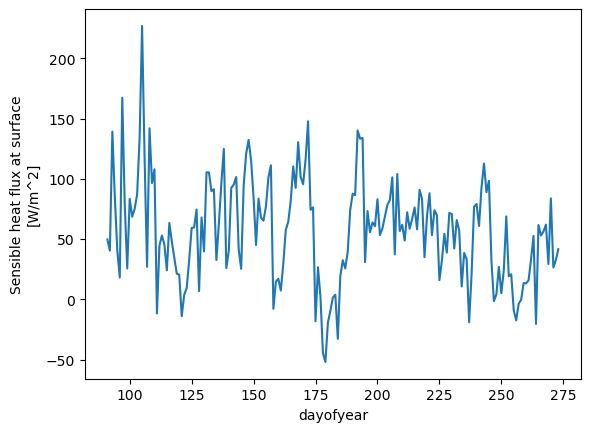

In [11]:
# We can use xarray funcationality to quickly plot up the data
h.plot()
plt.savefig(f'sensible_{date1}_{date2}_{n}.png')

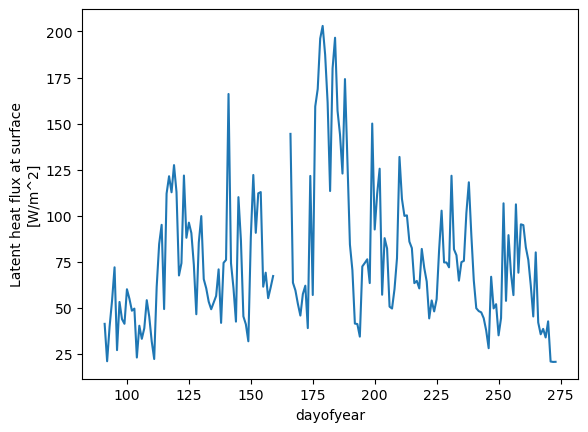

In [12]:
lv.plot()
plt.savefig(f'latent_{date1}_{date2}_{n}.png')

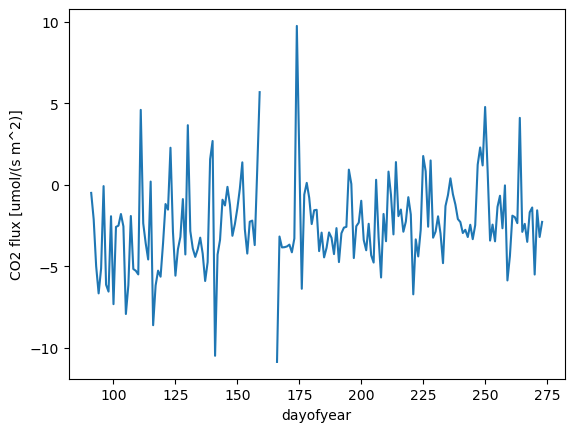

In [13]:
fc.plot()
plt.savefig(f'co2_{date1}_{date2}_{n}.png')

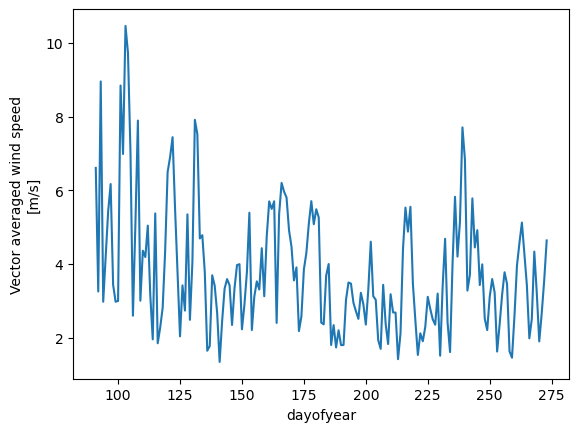

In [14]:
# Let's just make sure the wind data looks good as well
wspd.plot()
plt.savefig(f'wspd_{date1}_{date2}_{n}.png')


## Quality Control of ECOR Data

If you read through the ECOR instrument handbook, you may have noticed that at some sites, there is not sufficient fetch for the measurements and the data are suspect.  We need to be able to apply those limits to the data as well as filter the data based on the qc variables that are included in the file.  Additionally, ARM instrument experts (Mentors) routinely write data quality reports (DQR) on the data if there are problems.  This section will look at how to use all this information to QC the data.

In [15]:
# First, let's build a function that has the "Good" fetch directions defined
def get_arm_fetch(site, fac):
    """
 
 Each SGP ECOR site has specific directions where the fetch is good
    These ranges list are of good fetch directions
    """
    ranges=[]
    if site == 'sgp':
        if fac == 'E1':  #ECOR
            ranges = [[0, 53], [120, 360]]
        if fac == 'E2':  # EBBR
            ranges = [[71, 137], [223, 289]]
        if fac == 'E3':  #ECOR
            ranges = [[0, 48], [132, 260]]
        if fac == 'E4':  # EBBR
            ranges = [[0, 158], [202, 360]]
        if fac == 'E5':  #ECOR
            ranges = [[80, 154], [154, 260]]
        if fac == 'E6':  #ECOR
            ranges = [[0, 360]]
        if fac == 'E7':  # EBBR
            ranges = [[0, 244], [296, 360]]
        if fac == 'E8':  # EBBR
            ranges = [[0, 224], [314, 360]]
        if fac == 'E9':  # EBBR
            ranges = [[0, 360]]
        if fac == 'E10':  #ECOR
            ranges = [[0, 360]]
        if fac == 'E11':  # EBBR
            ranges = [[0, 360]]
        if fac == 'E12':  # EBBR
            ranges = [[0, 360]]
        if fac == 'E13':  # EBBR
            ranges = [[0, 52], [142, 194], [328, 360]]
        if fac == 'E14':  #ECOR
            ranges = [[129, 265], [352, 360], [0, 85]]
        if fac == 'E15':  # EBBR
            ranges = [[133, 360]]
        if fac == 'E16':  #ECOR
            ranges = [[134, 269], [334, 360]]
        if fac == 'E18':  # EBBR
            ranges = [[138, 325]]
        if fac == 'E19':  # EBBR
            ranges = [[0, 133], [151, 360]]
        if fac == 'E20':  # EBBR
            ranges = [[0, 230], [310, 360]]
        if fac == 'E21':  #ECOR
            ranges = [[30, 360]]
        if fac == 'E22':  # EBBR
            ranges = [[0, 49], [139, 360]]
        if fac == 'E24':  #ECOR
            ranges = [[80, 280]]
        if fac == 'E25':  # EBBR
            ranges = [[30, 360]]
        if fac == 'E26':  # EBBR
            ranges = [[0, 33], [243, 360]]
        if fac == 'E27':  # EBBR
            ranges = [[20,156]]
        if fac == 'E31':  #ECOR
            ranges = [[100, 200], [30, 80]]
        if fac == 'E32':  # EBBR
            ranges = [[0,360]]
        if fac == 'E33':  #ECOR
            ranges = [[100, 300], [40, 80]]
        if fac == 'E34':  # EBBR
            ranges = [[0,360]]
        if fac == 'E35':  # EBBR
            ranges = [[0,360]]
        if fac == 'E36':  # EBBR
            ranges = [[0,360]]
        if fac == 'E37':  #ECOR
            ranges = [[135, 260], [280, 310]]
        if fac == 'E38':  #ECOR
            ranges = [[150, 260]]
        if fac == 'E39':  #ECOR
            ranges = [[100, 260], [280, 360], [0, 80]]
        if fac == 'E40':  # EBBR
            ranges = [[0,360]]
        if fac == 'E41':  #ECOR
            ranges = [[100, 260], [280, 360], [0, 80]]

    return ranges

## Crop Type Information

ACT has a function to access crop type data from the [USDA Cropscape](https://nassgeodata.gmu.edu/CropScape) portal.  This is somewhat of an odd feature to have in ACT, but surface type information is very important to surface meteorological measurements.  For the given location, we will get crop data in 45-degree intervals for each year, and then group all the data into these intervals (or bins) based on wind direction.  This will allow us to match a crop type to each data point. 

In [25]:
urllib3.disable_warnings()
# Set a dummy wind direction variable
c_dir = np.arange(0, 361, 45)
lat = ds['lat'].values
lon = ds['lon'].values
time = ds['time'].values

# We will need the year for getting the crop type
year = time.astype('datetime64[Y]').astype(int) + 1970
unique_year = np.unique(year)
# Create a dictionary to house all the crop information
crops = []
crop_dict = {}
for yr in unique_year:
    if n == str(14) and yr == 2016 or n == str(14) and yr == 2017 or n == str(14) and yr == 2018 or n == str(14) and yr == 2019:
        crop = []
        for i, d in enumerate(c_dir):
            lat2, lon2 = act.utils.geo_utils.destination_azimuth_distance(lat[0], lon[0], d, 50)
            c = act.discovery.get_cropscape.croptype(lat2, lon2, yr)
            if c == 'Winter Wheat':
                c = 'Alfalfa'
            elif c == 'Oats':
                c = 'Alfalfa'
            elif c == 'Canola':
                c = 'Alfalfa'
            crop.append(c)
            crops.append(crop[i])
            print(crop[i], c_dir[i])
        if crop[0] == None:
            crop[0] = crop[-1]
        crop_dict[yr] = {'c_dir': c_dir, 'crop_type': crop}
    else:
        crop = []
        for i, d in enumerate(c_dir):
            lat2, lon2 = act.utils.geo_utils.destination_azimuth_distance(lat[0], lon[0], d, 50.)
            crop.append(act.discovery.get_cropscape.croptype(lat2, lon2, yr))
            crops.append(crop[i])
            print(crop[i], c_dir[i])
        if crop[0] == None:
            crop[0] = crop[-1]
        crop_dict[yr] = {'c_dir': c_dir, 'crop_type': crop}

Alfalfa 0
Grass/Pasture 45
Grass/Pasture 90
Grass/Pasture 135
Alfalfa 180
Alfalfa 225
Alfalfa 270
Alfalfa 315
Alfalfa 360


In [26]:
# Set bins and get data.  We want the crop types pulled earlier
# to be at the center of the bin so since we set the bins to 45º
# earlier, we want to shift them by half.  In doing this, we also
# have to add 0 back to the array so it properly bins for 0-22.5
bins = list(c_dir + 22.5)
bins = np.asarray([0] + bins)


# Get the data grouped by year as the crop type may
# change each yet
ds_year = ds.groupby('time.year')
# Get good fetch ranges for this site
site = ds.attrs['site_id']
fac = ds.attrs['facility_id']
ranges = get_arm_fetch(site, fac)
qc_ind = []
for r in ranges:
    qc_ind = np.concatenate((qc_ind, np.where((wdir >= r[0]) & (wdir <= r[1]))[0]))

# Set the QC variable for the wind direction.
qc_crop = np.zeros(len(wdir))
qc_crop[qc_ind.astype(int)] = 1
# Create an empty variable for the crop information
crop_type = np.empty(len(wdir), dtype=object)

# For each year, group the data by bins from earlier.
for yr in ds_year.groups.keys():
    ds_wind = ds_year[yr].groupby_bins('wind_dir', bins, labels=bins.astype(str)[:-1], include_lowest=True)
    
    # For each bin, set the crop type for all the corresponding data points
    for i, b in enumerate(bins[:-1].astype(str)):
        # We can get the indices of the data in the group easily
        ind = ds_wind.groups[b]
        crop_type[ind] = crop_dict[yr]['crop_type'][i]
        
# Add crop type and QC flag to existing object
atts = {'long_name': 'Crop type information based on wind direction as taken from CropScape',
            'units': 'unitless'}
da = xr.DataArray(data=crop_type, dims=ds['wind_dir'].dims, name='crop_type', attrs=atts)
ds['crop_type'] = da
ds.qcfilter.create_qc_variable('crop_type',flag_type=True)
ds['qc_crop_type'].values = qc_crop
ds['qc_crop_type'].attrs['flag_values'] = [0,1]
ds['qc_crop_type'].attrs['flag_meanings'] = ['Sufficient Fetch','Insufficient Fetch']
ds['qc_crop_type'].attrs['flag_assessments'] = ['Good','Suspect']

### What crops are we working with?
Rather than trying to figure out each unique crop by looking at every single data point, we can create a list that lists each crop only once.

In [27]:
#Create a list that includes all the crops with at least two data points and does not include "None"
crops_all=[]
for f in range(0, len(crops)):
    if crops[f] != None:
        if len(np.where(ds.crop_type == ds.crop_type[f])[0]) > 1:
            crops_all.append(crops[f])
#Now use the list created above to create a unique crop list
crop_list = np.unique(crops_all)
crop_list

array(['Alfalfa', 'Grass/Pasture'], dtype='<U13')

### Putting it All Together

We have the ECOR data, we have the crop data, now let's look at the results!  Here we have it so that the code will cycle through the crop list we created earlier and generate a series of graphs for each crop type.

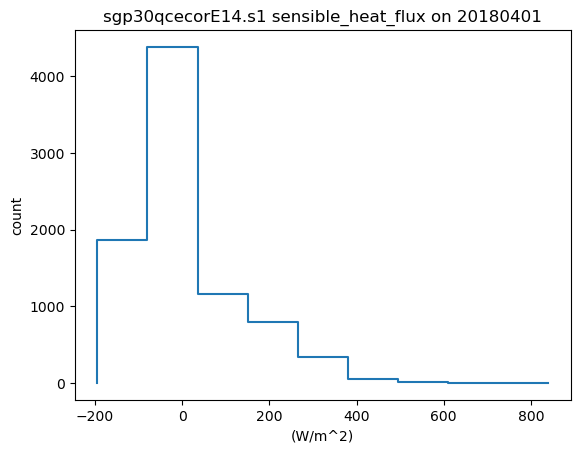

In [28]:
#Histograms of overall data
hist = act.plotting.HistogramDisplay(ds)
hist.plot_stairstep_graph('sensible_heat_flux')
plt.savefig(f'histogram_h_{date1}_{date2}_{n}.png')

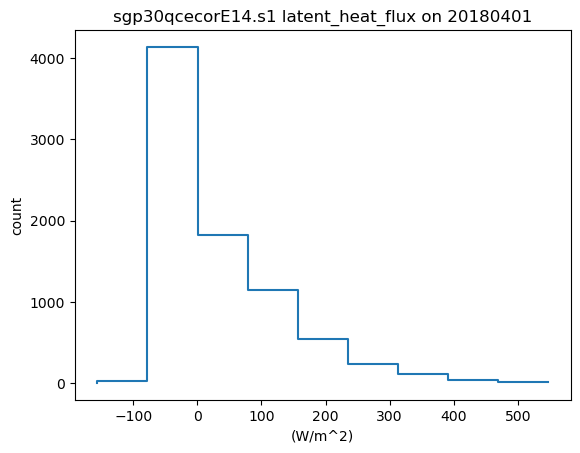

In [29]:
hist = act.plotting.HistogramDisplay(ds)
hist.plot_stairstep_graph('latent_heat_flux')
plt.savefig(f'histogram_lv_{date1}_{date2}_{n}.png')

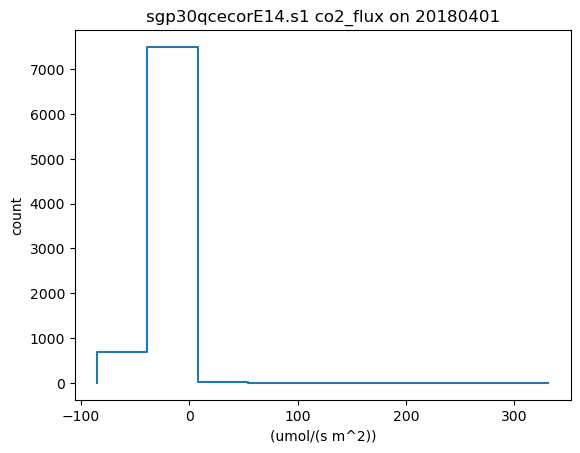

In [30]:
hist = act.plotting.HistogramDisplay(ds)
hist.plot_stairstep_graph('co2_flux')
plt.savefig(f'histogram_fc_{date1}_{date2}_{n}.png')

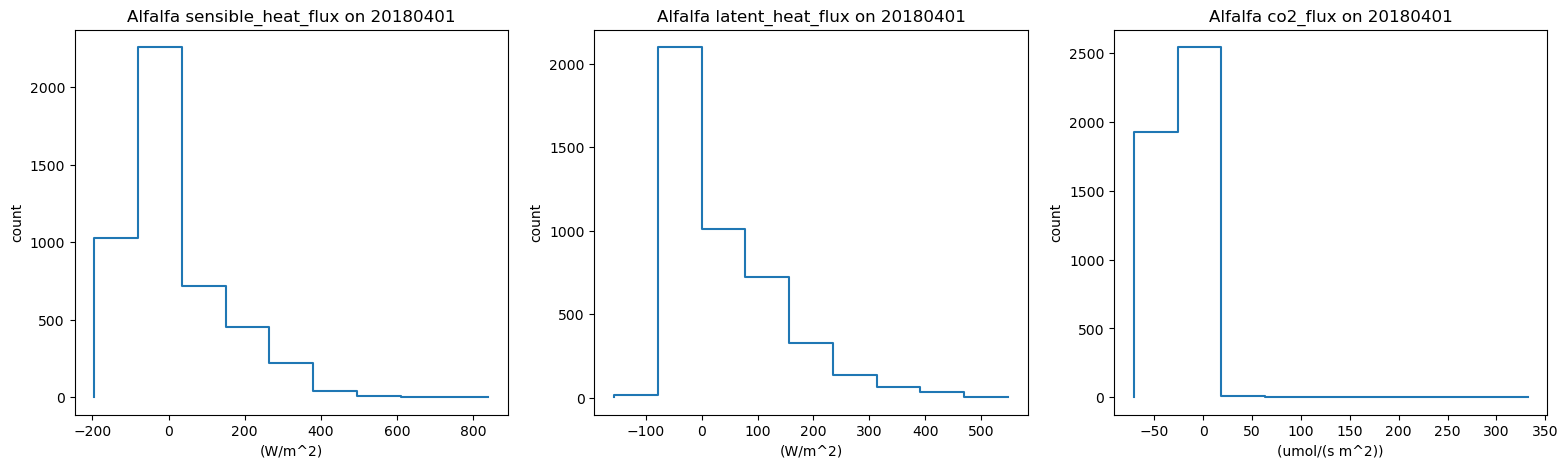

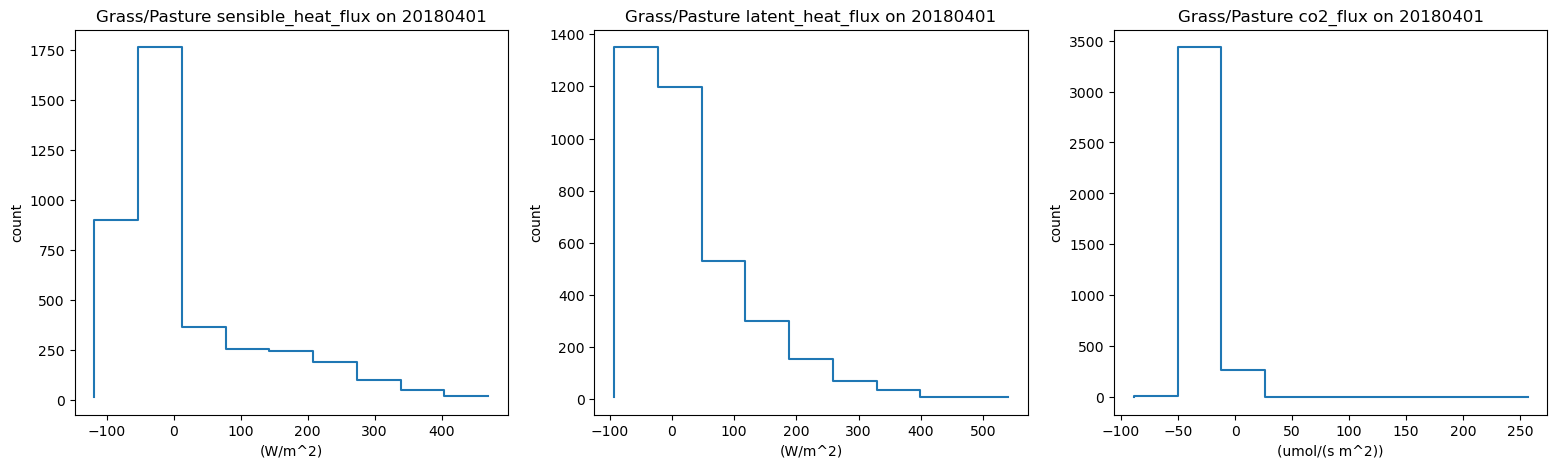

In [31]:
#Histograms based on crop type
for x in range(0, len(crop_list)):  
    ds3 = ds.where(ds.crop_type == f'{crop_list[x]}')
    hist = act.plotting.HistogramDisplay({f'{crop_list[x]}': ds3}, subplot_shape=(1,3), figsize=(19, 5))
    ax = hist.plot_stairstep_graph('sensible_heat_flux', dsname=f'{crop_list[x]}', subplot_index=(0,0), label=f'{crop_list[x]}')
    ax = hist.plot_stairstep_graph('latent_heat_flux', dsname=f'{crop_list[x]}', subplot_index=(0,1), label=f'{crop_list[x]}')
    ax = hist.plot_stairstep_graph('co2_flux', dsname=f'{crop_list[x]}', subplot_index=(0,2), label=f'{crop_list[x]}')
    plt.savefig(f'histograms_{x}_{date1}_{date2}_{n}.png')

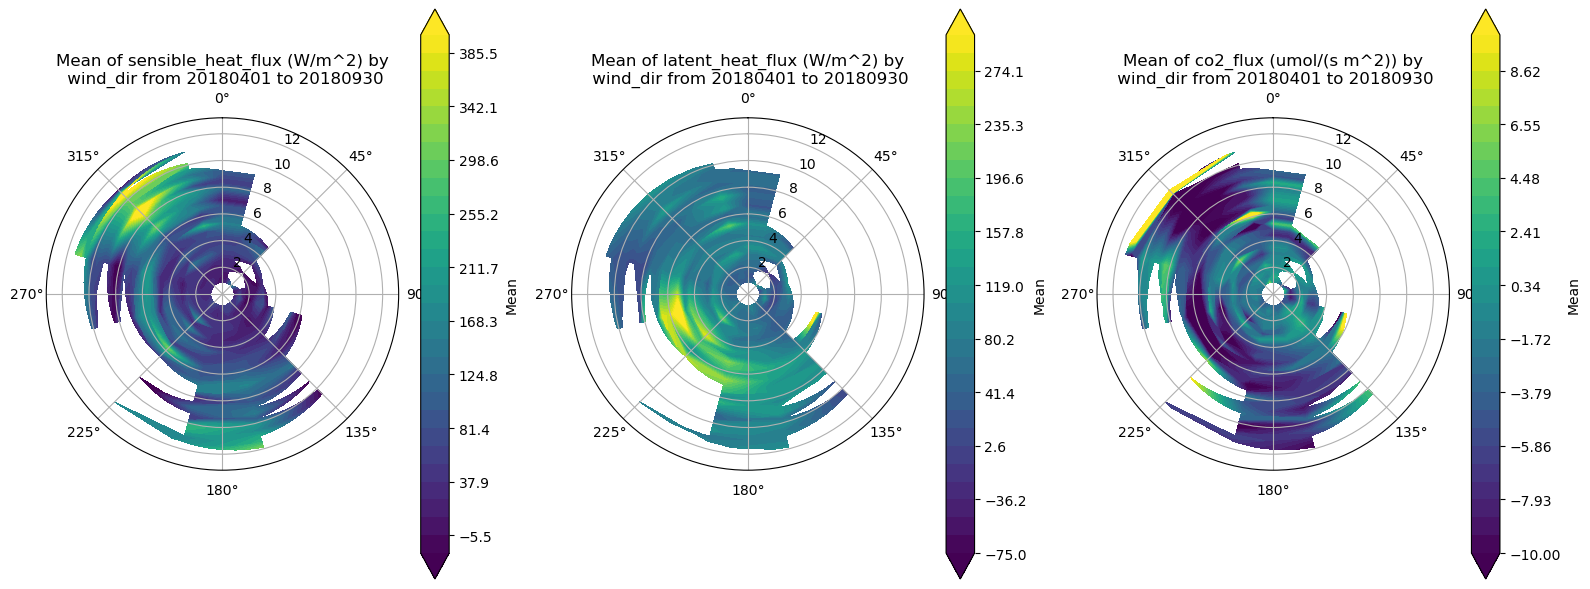

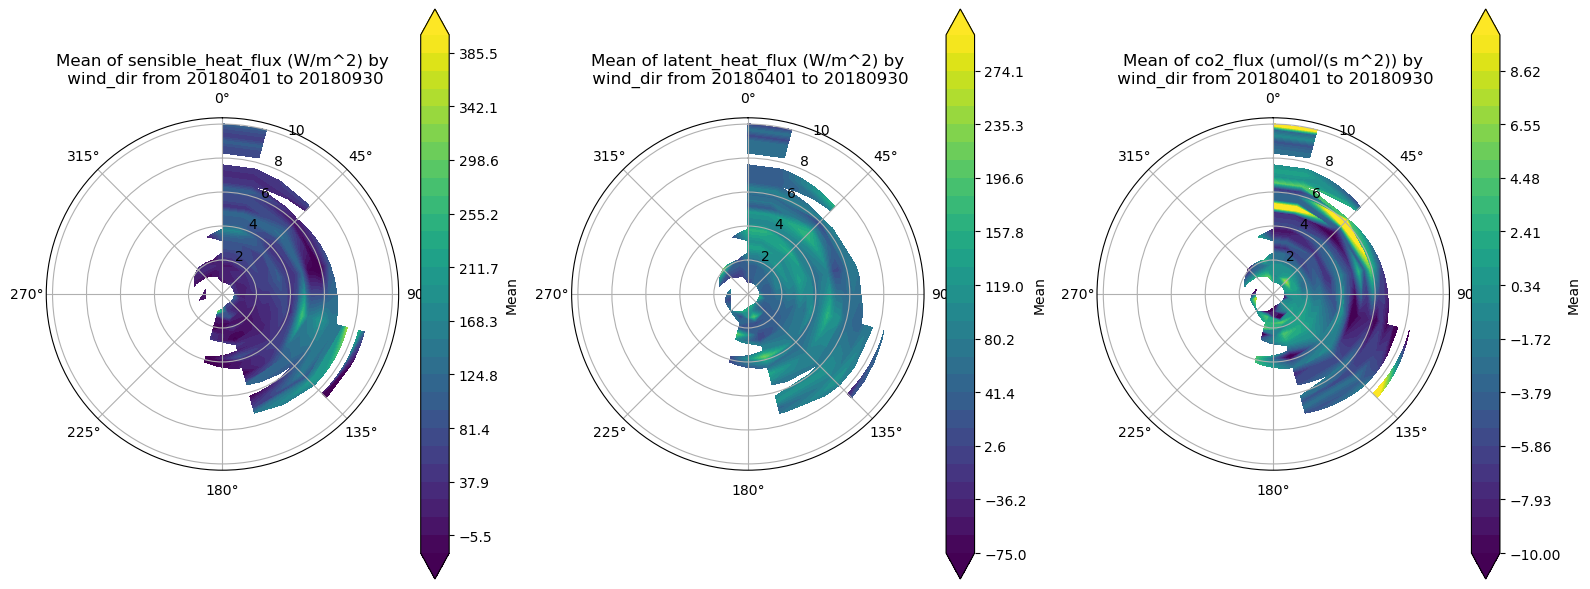

In [32]:
#Wind rose plots
#Pay attention to the directions listed for each crop type earlier.  
#This will tell you which part of the roses you should be paying attention to for each crop type.
for x in range(0, len(crop_list)):
    ds3 = ds.where(ds.crop_type == f'{crop_list[x]}')
    display = act.plotting.WindRoseDisplay({f'{crop_list[x]}': ds3},
                                           subplot_shape=(1,3), figsize=(16,6))
    ax = display.plot_data('wind_dir', 'wind_spd', 'sensible_heat_flux', num_dirs=12, plot_type='contour', 
                      dsname=f'{crop_list[x]}', subplot_index=(0,0), contour_type='mean', vmin=-20, vmax=400)
    ax = display.plot_data('wind_dir', 'wind_spd', 'latent_heat_flux', num_dirs=12, plot_type='contour', 
                      dsname=f'{crop_list[x]}', subplot_index=(0,1), contour_type='mean', vmin=-75, vmax=300)
    ax = display.plot_data('wind_dir', 'wind_spd', 'co2_flux', num_dirs=12, plot_type='contour', 
                      dsname=f'{crop_list[x]}', subplot_index=(0,2), contour_type='mean', vmin=-10, vmax=10)
    plt.figure(ax.figure)
    plt.savefig(f'Windroseplots_{x}_{date1}_{date2}_{n}.png')

## Resources and references

### Datasets used in this example
Xie, S. Quality Controlled Eddy Correlation Flux Measurement (30QCECOR). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1097546

Sullivan, R., Billesbach, D., Keeler, E., & Ermold, B. Eddy Correlation Flux Measurement System (30ECOR). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1025039

### Cropscape Citations
Han, W., Yang, Z., Di, L., Yue, P., 2014. A geospatial Web service approach for creating on-demand Cropland Data Layer thematic maps. Transactions of the ASABE, 57(1), 239-247.

Han, W., Yang, Z., Di, L., Yagci, A., Han, S., 2014. Making Cropland Data Layer data accessible and actionable in GIS education. Journal of Geography, 113(3), 129-138.

Han, W., Yang, Z., Di, L., Mueller, R., 2012. CropScape: A Web service based application for exploring and disseminating US conterminous geospatial cropland data products for decision support. Computers and Electronics in Agriculture, 84, 111–123.

Boryan, C., Yang, Z., Willis, P., 2014. US geospatial crop frequency data layers. Third International Conference on Agro-geoinformatics (Agro-geoinformatics 2014), August 11-14, 2014, Beijing, China.

Boryan, C., Yang, Z., Mueller, R., Craig, M., 2011. Monitoring US agriculture: the US Department of Agriculture, National Agricultural Statistics Service, Cropland Data Layer Program. Geocarto International, 26(5), 341–358. 

### ARM Instrument Handbook
Cook, D. R. (2018). Eddy correlation flux measurement system (ECOR) instrument handbook (No. DOE/SC-ARM-TR-052). DOE Office of Science Atmospheric Radiation Measurement (ARM) Program (United States).

Tang, S., Xie, S., Zhang, Y., & Cook, D. R. (2019). The QCECOR Value-Added Product: Quality-Controlled Eddy Correlation Flux Measurements (No. DOE/SC-ARM-TR-223). DOE Office of Science Atmospheric Radiation Measurement (ARM) Program (United States).

### Creators
This notebook was put together by Nick Markus using an initial notebook by Adam Theisen.